In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import nltk
from wordcloud import WordCloud, STOPWORDS
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [2]:
from google.colab import drive
drive.mount('/content/drive')
data = "/content/drive/Shared drives/ece143_proj/data_cleaned.csv"


Mounted at /content/drive


In [ ]:
#need origional df
from google.colab import drive
drive.mount('/content/drive')
ROOT_DIR = "/content/drive/Shared drives/ece143_proj"
txt_path = '/data.csv'
df_initial = pd.read_csv(ROOT_DIR+txt_path,encoding = "ISO-8859-1",dtype={'InvoiceID':str,'CustomerID':str})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#exploring content of variables
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
#print(tab_info)
display(tab_info)
#display(df_initial.head())
display(df_initial)

df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.rename(index={0:'null values (%)'}))
df_initial.drop_duplicates(inplace = True)

display(tab_info)

In [ ]:
### display number of orders per country
amount = df_initial.groupby('Country')['Country'].count().sort_values(ascending = False)
amount_df = pd.DataFrame(amount)
other_amt = amount_df[amount_df['Country']<5000].sum()
amount_gen = amount_df[amount_df['Country']>= 5000]
amount_gen.loc['Other'] = other_amt

amount_gen.plot.pie(subplots = True, ylabel = "")
plt.title('Purchases by Country')
plt.legend(title = "Country:")
plt.show() 



cancel prod:  order_canceled
0    18536
1     3654
Name: order_canceled, dtype: int64


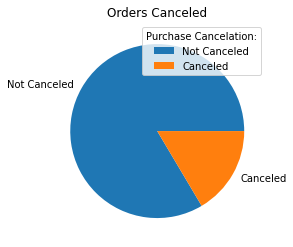

In [ ]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]

df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
        # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break    

#canceled order change 1 to canceled 0 to not canceled
cancel_prod = nb_products_per_basket.groupby('order_canceled')['order_canceled'].count().sort_values(ascending = False)
print('cancel prod: ', cancel_prod)
cancel_prod.plot.pie(subplots = True, ylabel = "", labels = ['Not Canceled', 'Canceled'])
#plt.pie(cancel_prod) 
plt.legend(title = "Purchase Cancelation:")
plt.title("Orders Canceled")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  app.launch_new_instance()


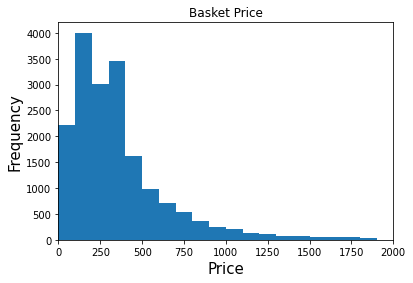

In [ ]:
#part 1.5
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtfull_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]

#part 1.6
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes
for code in list_special_codes:
    df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

#part 1.7
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])


basket_price = basket_price[basket_price['Basket Price'] > 0]
#basket_price.sort_values('CustomerID')[:6]

bp_data = basket_price['Basket Price']
plt.hist(bp_data, bins = np.arange(0,2000,100))
plt.title('Basket Price')
plt.xlabel('Price', fontsize = 15, color = 'k')
plt.ylabel('Frequency', fontsize = 15, color = 'k')
plt.xlim(xmin=0,xmax = 2000)
plt.show()

In [ ]:
df_cleaned = pd.read_csv(data)
print(df_cleaned.head())

   Unnamed: 0  InvoiceNo StockCode                          Description  \
0           0     536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER   
1           1     536365     71053                  WHITE METAL LANTERN   
2           2     536365    84406B       CREAM CUPID HEARTS COAT HANGER   
3           3     536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE   
4           4     536365    84029E       RED WOOLLY HOTTIE WHITE HEART.   

   Quantity          InvoiceDate  UnitPrice  CustomerID         Country  \
0         6  2010-12-01 08:26:00       2.55       17850  United Kingdom   
1         6  2010-12-01 08:26:00       3.39       17850  United Kingdom   
2         8  2010-12-01 08:26:00       2.75       17850  United Kingdom   
3         6  2010-12-01 08:26:00       3.39       17850  United Kingdom   
4         6  2010-12-01 08:26:00       3.39       17850  United Kingdom   

   Canceled  
0         0  
1         0  
2         0  
3         0  
4         0  


In [ ]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
        for s in keywords_roots.keys():
          if len(keywords_roots[s]) > 1:  
              min_length = 1000
              for k in keywords_roots[s]:
                  if len(k) < min_length:
                      clef = k
                      min_length = len(k)

              category_keys.append(clef)
              keywords_select[s] = clef
          else:
              category_keys.append(list(keywords_roots[s])[0])
              keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Num of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [ ]:
df_produits = pd.DataFrame(df_cleaned['Description'].unique()).rename(columns = {0:'Description'})
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Num of keywords in variable 'Description': 3732227


In [ ]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
 
list_products.sort(key = lambda x:x[1], reverse = True)

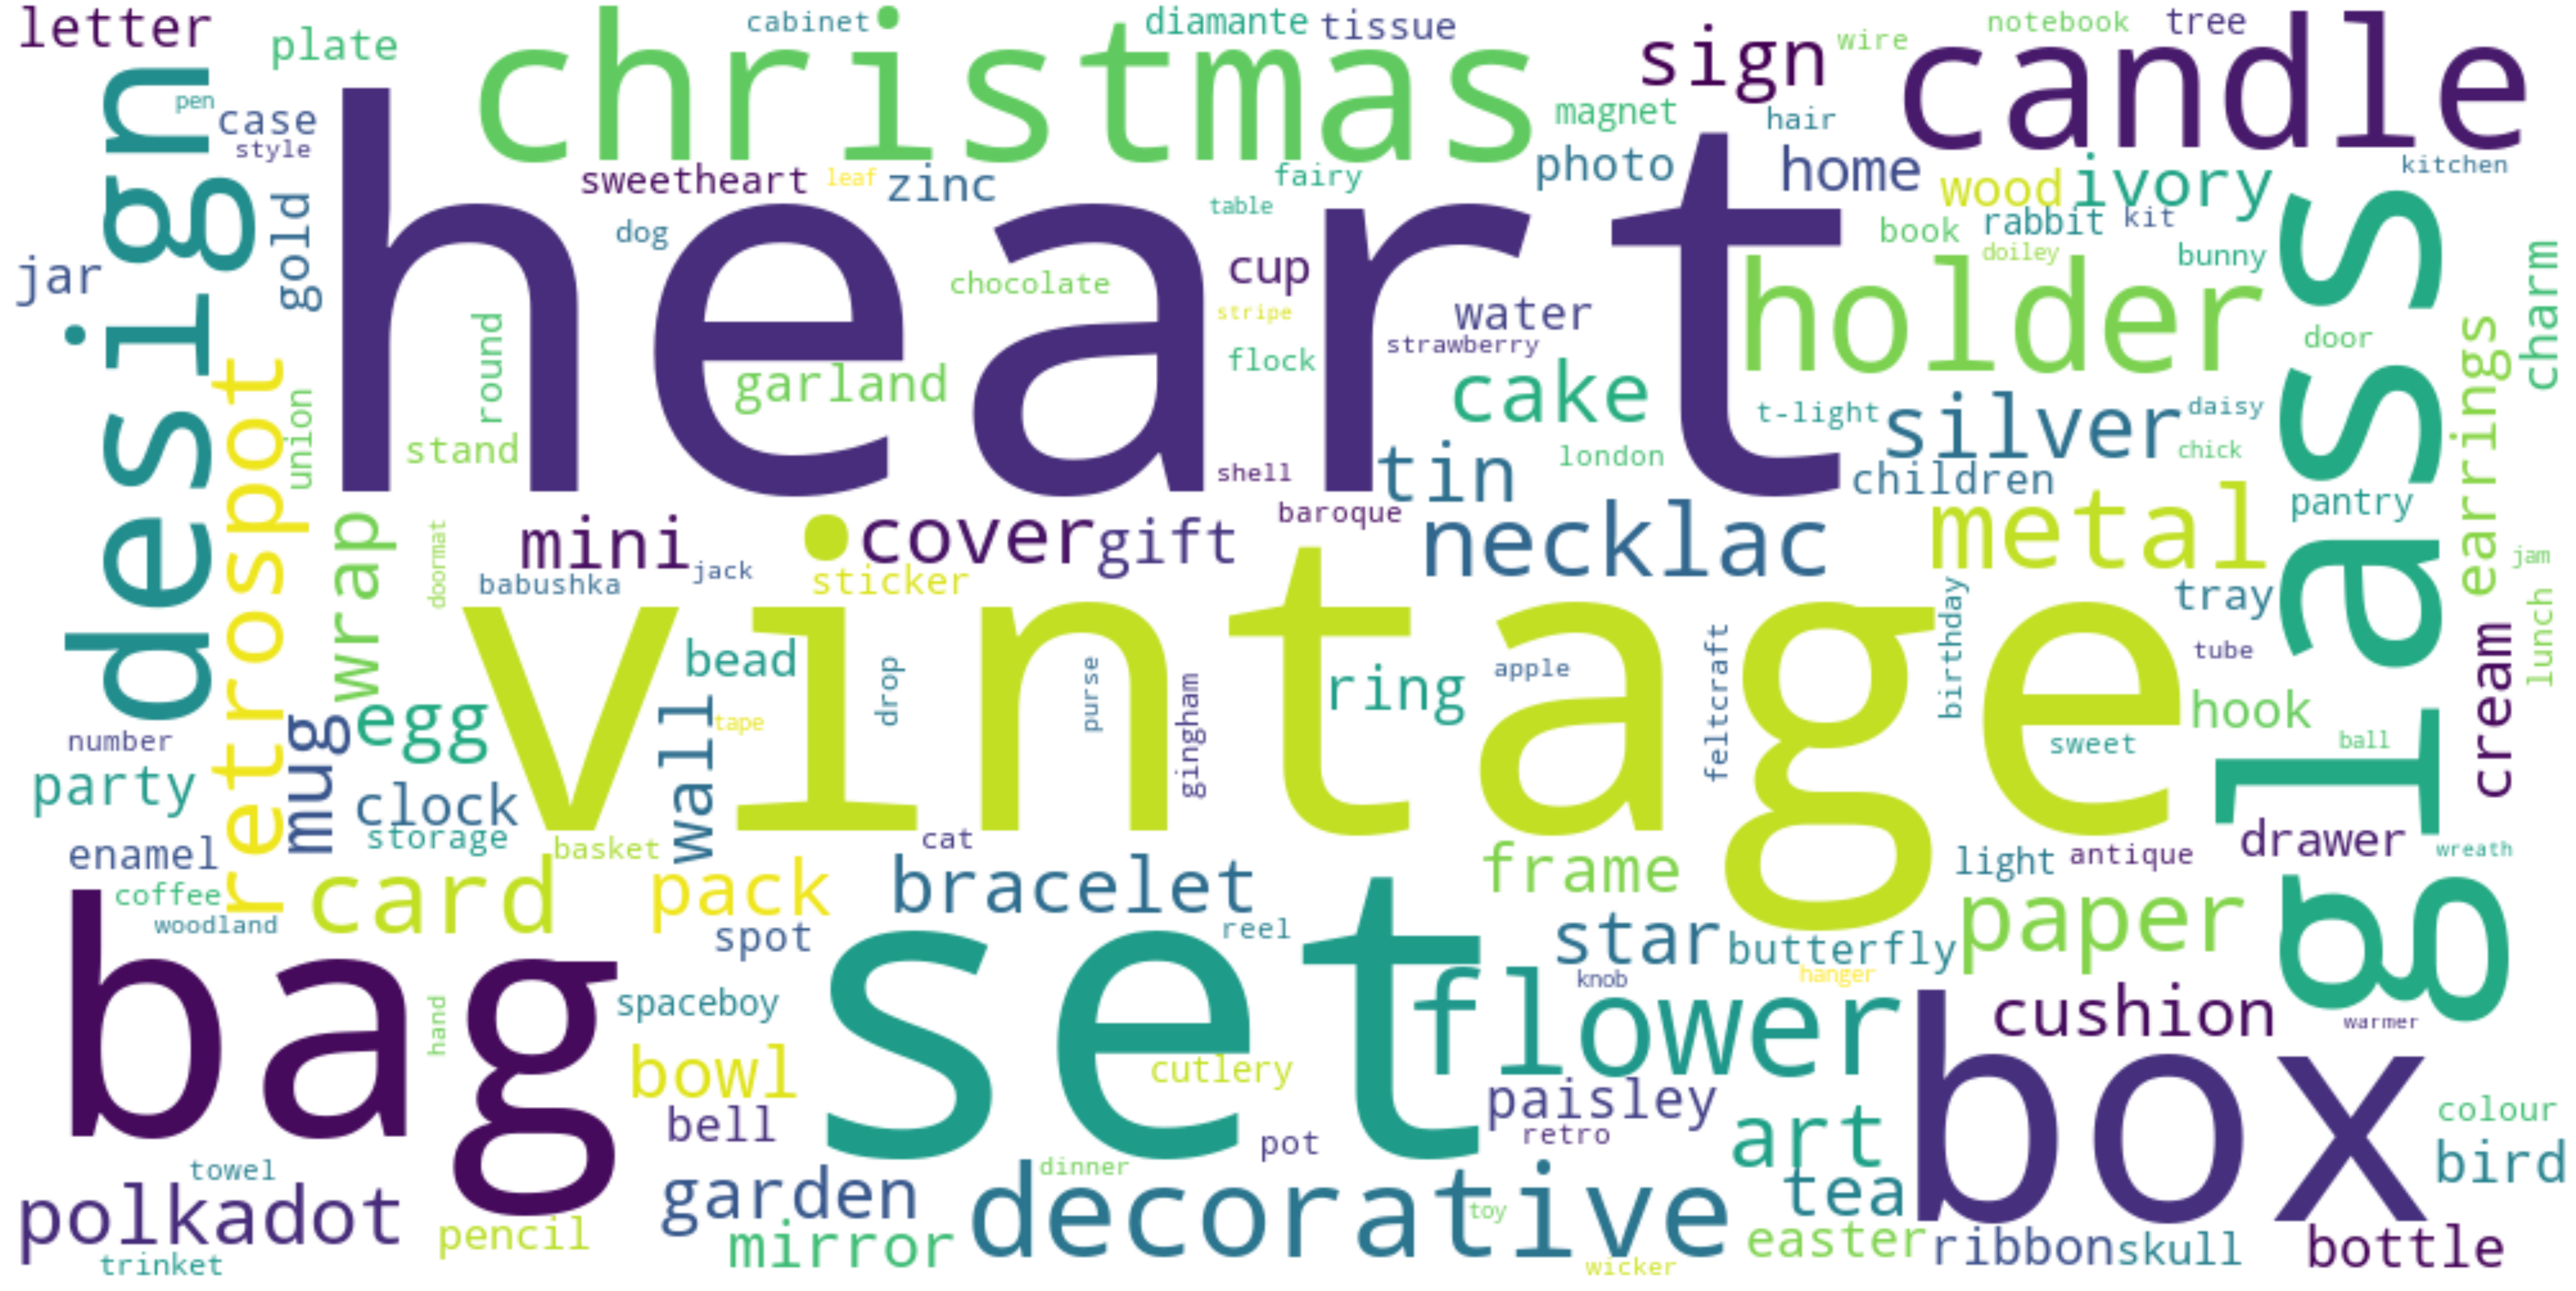

In [ ]:
def makeWordCloud(frequencyList):
    '''
    input: a nested list, the first element in the inner list: a string presenting a product,
    the second element in the inner list: the frequency of the product
    output: show a word cloud
    '''
    words = dict()
    for innerList in frequencyList:
        words[innerList[0]] = innerList[1]
        
    wordcloud = WordCloud(width=1000,height=500, background_color='white', 
                          max_words=150,relative_scaling=1,
                          color_func = None,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    
    fig = plt.figure(1, figsize=(100,100))
    axis = fig.add_subplot(1,1,1)
    axis.imshow(wordcloud, interpolation="bilinear")
    axis.axis('off')

makeWordCloud(list_products)

In [ ]:
list_product = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), list_product))

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [ ]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(list_product):
    prix = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.obj[key] = value


In [ ]:
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = 5, n_init=30)
    kmeans.fit(X)
    clusters = kmeans.predict(X)
    silhouette_avg = silhouette_score(X, clusters)

corresp = dict()
for key, val in zip (list_product, clusters):
    corresp[key] = val 

df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [ ]:
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = []
doubtfull_entry = []

for index, col in  df_cleaned.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_cleaned[(df_cleaned['CustomerID'] == col['CustomerID']) &
                         (df_cleaned['StockCode']  == col['StockCode']) & 
                         (df_cleaned['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_cleaned['Quantity']   > 0)].copy()

    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)

    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        

    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break   

In [ ]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)

df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

In [ ]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

In [ ]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

In [ ]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

In [ ]:
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    #print(temp)
    basket_price.loc[:, col] = temp[col]

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [ ]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

In [ ]:
from datetime import datetime
before = list(df_cleaned['InvoiceDate'])
after = [0] * len(before)
i = 0
for i in range(len(before)):
  after[i] = (datetime.fromisoformat(before[i]) - datetime(2010, 11, 30)).total_seconds()
df_cleaned['InvoiceDate_int'] = after
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

In [ ]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In part, I find that this type of customer represents 1/3 of the customers listed:

In [ ]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("Proportion of customers who only made one purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

In [ ]:
labels = 'Several times', 'Only Once'
sizes = [2838, 1489]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

The dataframe transactions_per_user contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [ ]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
X = selected_customers[list_cols]

 create a matrix where these data are standardized:

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)
pca = PCA(n_components=6)
pca.fit(scaled_X)
n_clusters = 11

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_X)
clusters_clients = kmeans.predict(scaled_X)
selected_customers.loc[:, 'cluster'] = clusters_clients

In [ ]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

In [ ]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts". (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave%20-read-this))

This allows us to have a global view of the content of each cluster:

In [ ]:
class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

In [ ]:
fig = plt.figure(figsize=(16,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_clusters = 11
n_groups = n_clusters 
i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes]) +1   
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster {}'.format(index[ind]+1), color = 'r')
    ind += 1 

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages ( mean ), the total sum spent by the clients ( sum ) or the total number of visits made ( count ).

In [ ]:
import plotly.express as px

prices = df_cleaned[['InvoiceDate', 'Country', 'UnitPrice']]
countries_ = [c for c in prices['Country'].unique()]
countries = countries_[1:]
prices['InvoiceDate'] = prices['InvoiceDate'].str[:10]

In [ ]:
import itertools

mapp = dict()
for i in range(len(countries_)):
  tmp = prices.loc[prices['Country'] == countries_[i]]
  mapp[countries_[i]] = len(tmp)


mapp = dict(sorted(mapp.items(), key=lambda item: item[1], reverse=True))
top10 = list(mapp.items())[:10]
top10 = [k for k,v in top10]
top10

In [ ]:
group_country = prices.groupby(['Country', 'InvoiceDate']).sum()
df = pd.DataFrame(group_country, columns = ['UnitPrice'], index= group_country.index)
df.reset_index(inplace=True)

M = df.loc[df['Country'] == 'United Kingdom']
for i in countries:
  tmp = df.loc[df['Country'] == i]
  tmp = tmp.drop(['Country'], axis=1)
  M = pd.merge(M, tmp, how="left", on=["InvoiceDate"])

M = M.drop(['Country'], axis=1)
M.columns = ['InvoiceDate','United Kingdom'] + countries
M.columns.name = 'country'
M = M.set_index('InvoiceDate')
M.head()
M1 = M

In [ ]:
fig = px.bar(M, x=M.index, y="United Kingdom")
fig.show()
fig = px.bar(M, x=M.index, y="Germany")
fig.show()

In [ ]:
fig = px.area(M[top10], facet_col="country", facet_col_wrap=2)
fig.show()

Do the same thing on trading quantity.

In [ ]:
quantity = df_cleaned[['InvoiceDate', 'Country', 'Quantity']]
# add up all amount of items
quantity['InvoiceDate'] = quantity['InvoiceDate'].str[:10]
group_quantity = quantity.groupby(['Country', 'InvoiceDate'])['Quantity'].count()
df = pd.DataFrame(group_quantity, columns = ['Quantity'], index= group_quantity.index)
df.reset_index(inplace=True)

In [ ]:
M = df.loc[df['Country'] == 'United Kingdom']
for i in countries:
  tmp = df.loc[df['Country'] == i]
  tmp = tmp.drop(['Country'], axis=1)
  M = pd.merge(M, tmp, how="left", on=["InvoiceDate"])

M = M.drop(['Country'], axis=1)
M.columns = ['Quantity','United Kingdom'] + countries
M.columns.name = 'country'
M = M.set_index('Quantity')
M2 = M
M.head()

In [ ]:
fig = px.bar(M, x=M.index, y="United Kingdom")
fig.show()
fig = px.bar(M, x=M.index, y="Germany")
fig.show()

In [ ]:
fig = px.area(M[top10], facet_col="country", facet_col_wrap=2)
fig.show()

In [ ]:
import plotly.express as px

M1.head()

alpha_map = {'France': 'FRA', 'United Kingdom': 'GBR', 'Australia': 'AUS', 'Netherlands': 'NLD', 'Germany': 'DEU',
             'Norway': 'NOR', 'EIRE': 'IRL', 'Switzerland': 'CHE', 'Spain': 'ESP' ,'Poland': 'POL', 'Portugal': 'PRT', 'Italy': 'ITA',
             'Belgium': 'BEL', 'Lithuania': 'LTU', 'Japan': 'JPN', 'Iceland': 'ISL', 'Denmark': 'DNK', 'Channel Islands': -1,
             'Cyprus': 'CYP', 'Sweden': 'SWE', 'Austria': 'AUT', 'Israel': 'ISR', 'Finland': 'FIN', 'Greece': 'GRC', 'Singapore': 'SGP',
             'Lebanon': 'LBN', 'United Arab Emirates': 'ARE', 'Saudi Arabia': 'SAU', 'Czech Republic': 'CZE', 'Canada': 'CAN',
             'Unspecified': -1, 'Brazil': 'BRA', 'USA': 'USA', 'Bahrain': 'BHR', 'European Community': -1, 'Malta':'MLT', 'RSA': -1}


In [ ]:
continent_map = {'United Kingdom': 'Europe', 'France': 'Europe', 'Australia': 'Asia', 'Netherlands': 'Europe', 'Germany': 'Europe',
                'Norway': 'Europe',  'EIRE': 'Europe', 'Switzerland': 'Europe', 'Spain': 'Europe', 'Poland': 'Europe', 'Portugal': 'Europe',
                'Italy': 'Europe', 'Belgium': 'Europe', 'Lithuania': 'Europe', 'Japan': 'Asia', 'Iceland': 'Europe', 'Channel Islands': -1, 
                'Denmark': 'Europe', 'Cyprus': 'Europe', 'Sweden': 'Europe', 'Austria': 'Europe', 'Israel': 'Asia', 'Finland': 'Europe', 'Greece': 'Europe',
                'Singapore': 'Asia', 'Lebanon': 'Asia', 'United Arab Emirates': 'Asia','Saudi Arabia': 'Asia', 'Czech Republic': 'Europe', 'Canada': 'North America',
                'Unspecified': -1, 'Brazil': 'South America', 'USA': 'North America', 'European Community': -1, 'Bahrain': 'Asia', 'Malta': 'Europe', 'RSA': -1}

In [ ]:
label_alpha = pd.DataFrame([alpha_map[countries[i]] for i in range(len(countries))])
label_con = pd.DataFrame([continent_map[countries[i]] for i in range(len(countries))])
M2['iso_alpha'] = label_alpha
M2['continent'] = label_con

In [ ]:
Q = df_cleaned[['Country', 'Quantity']]
QQ = pd.DataFrame(Q.groupby('Country')['Quantity'].sum())
QQ = pd.DataFrame(QQ, columns = ['Quantity'], index = QQ.index)
QQ.reset_index(inplace=True)
QQ['iso_alpha'] = pd.DataFrame([alpha_map[l] for l in QQ['Country']])
QQ['continent'] = pd.DataFrame([continent_map[l] for l in QQ['Country']])
QQ.drop(QQ[QQ['iso_alpha'] == -1].index, inplace = True)
QQ.drop(QQ[QQ['continent'] == -1].index, inplace = True)

In [ ]:
fig = px.scatter_geo(QQ, locations="iso_alpha", color="continent",
                     hover_name="Country", size="Quantity", projection='natural earth')
fig.show()

In [ ]:
QQ.loc[QQ['Country'] != 'United Kingdom', 'country'] = 'Other countries'
QQ.loc[QQ['Country'] == 'United Kingdom', 'country'] = 'United Kingdom'
fig = px.pie(QQ, values='Quantity', names='country', title='Quantity of Buying in different Countries - UK v.s. Others')
fig.show()

# we already know UK has the largest ammount of buying, we want to see other countries so we drop it, otherwise the plot would be hard to interpret.
QQ_ = QQ.drop(labels=35, axis=0)
fig = px.pie(QQ_, values='Quantity', names='Country', title='Quantity of Buying in different Countries')
fig.show()